# Accounting for PSF distortion

The distortion in the PSF is introduced through a combination of shear and stretch transformations. 
The parameters of this mapping at each image position are read from first degree polynomials, whose coefficients are fitted to the data.
Namely, we apply the following affine transformation to the narrow PSF during the fitting procedure:
$$ \mathbf{A} = \begin{pmatrix}
\mathrm{dilation}_x & \mathrm{shear} \\
\mathrm{shear} & \mathrm{dilation}_y
\end{pmatrix} $$

where the parameters depend on the image position through

$$ \mathrm{dilation}_x = 1 + a_{0}x + a_{1}y $$
$$ \mathrm{dilation}_y = 1 + b_{0}x + b_{1}y $$
$$ \mathrm{shear} = c_{0}x + c_{1}y. $$

We assume that the origin of the $x, y$ coordinates are the center of the image.
Note that setting all distortion coefficients to 0 results in no distortion.

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import json

from starred.procedures import build_psf

np.seterr(all="ignore")
data_path = Path('../../tests/data/psf_distortion_data/')


## Data importation
The following data come from a 1-m telescope of the LCO network. It shows some light PSF distortion across the field.

In [2]:
stars = np.load(data_path / 'stamps.npy')
noisemaps = np.load(data_path / 'noisemaps.npy')
stamp_coordinates = np.load(data_path / 'stars_positions.npy')

Not obviously visible by eye ... but we not a change of the orientation of the "trailing" at the top.

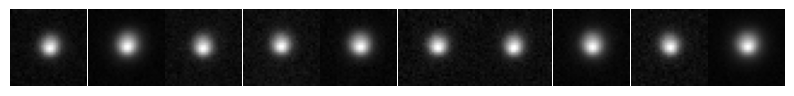

In [3]:
fig, axs = plt.subplots(1,10, figsize=(10, 1))
for ax, star, noisemap in zip(axs, stars, noisemaps):
    ax.imshow(star/noisemap, cmap='gray'); ax.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

## PSF fit without distortion

/home/fred/Documents/starred_dev/starred/starred/utils/noise_utils.py:53: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)
optax.adabelief: 100%|█████████████████████| 2000/2000 [00:14<00:00, 138.30it/s]


1.1828641


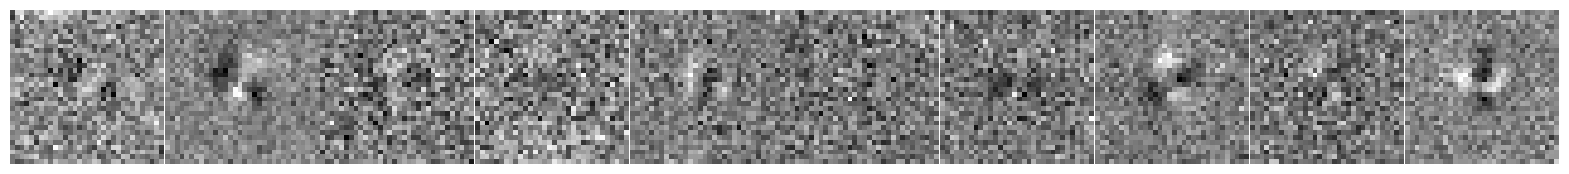

In [4]:
result_no_distortion = build_psf(stars, noisemaps, subsampling_factor=2)
fig, axs = plt.subplots(1,10, figsize=(20,2))
for ax, res, noisemap in zip(axs, result_no_distortion['residuals'], noisemaps):
    ax.imshow(res/noisemap, cmap='gray'); ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
print(result_no_distortion['chi2'])

We do see residuals that we can (at least partially) account for with our very simple distortion model. 

## PSF fit with distortion

We need to provide the pixel positions of the stars we extracted of the field. The origin of the coordinates should be kept at the center of the image. Provide the `build_psf` function with the `stamp_coordinates` argument, an array of shape $(N, 2)$: with $N$ being the number of stars you are fitting at once.

In [5]:
stamp_coordinates.shape

(10, 2)

For the sake of numerical stability, always introduce some rescaled image coordinates. Later, you will need to use the same rescaling when querying the PSF model at different positions in your image.

In [6]:
stamp_coordinates_scaled = stamp_coordinates / 500.

/home/fred/Documents/starred_dev/starred/starred/utils/noise_utils.py:53: RuntimeWarning: Mean of empty slice
  noise_map = np.nanmean(centered_masked_noise_maps, axis=0)
optax.adabelief: 100%|██████████████████████| 1000/1000 [00:11<00:00, 85.27it/s]


1.055415


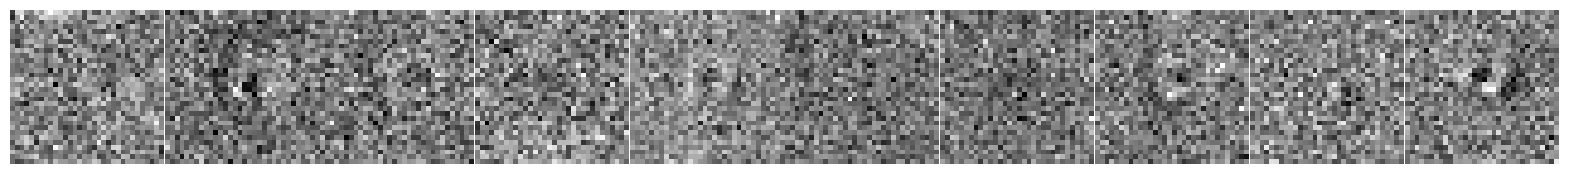

In [7]:
result = build_psf(stars, noisemaps, subsampling_factor=2, field_distortion=True, stamp_coordinates=stamp_coordinates_scaled)

fig, axs = plt.subplots(1,10, figsize=(20,2))
for ax, res, noisemap in zip(axs, result['residuals'], noisemaps):
    ax.imshow(res/noisemap, cmap='gray'); ax.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
print(result['chi2'])

We corrected for at least some of the residuals! Our reduced chi-squared was also improved.

Doing so slowed down the generation of the PSF considerably, because
1. We have an extra interpolation step during the generation of the model (interpolating the narrow PSF to the coordinates transformed by the inverse of the $A$ matrix defined at the top of this notebook),
2. We first fit the PSF as usual, then free the distortion in a second step, adding more iterations of the optimizer.

## Extracting the PSF model at given coordinates

Now we provide an example showing how to extract the PSF model given coordinates (do not forget the rescaling we performed earlier!)

In [8]:
# just unpacking the PSF instances and parameters.
model_no_distortion = result_no_distortion['model_instance']
kwargs_no_distortion = result_no_distortion['kwargs_psf']

model = result['model_instance']
kwargs = result['kwargs_psf']

In [9]:
def get_psf_at_position(position, model, kwargs):
    # if you are interested in the actual PSF (generic)
    # position is an array of shape (2, ) containing your rescaled coordinates, i.e. (x, y)
    return np.array(model.get_full_psf(**kwargs, position=position))

def get_narrow_psf_at_position(position, model, kwargs):
    # if you are instead  interested in the narrow PSF (used in starred deconvolutions)
    return np.array(model.get_narrow_psf(**kwargs, position=position))

Let us compare the PSF models with and without distortion at the position of one of the stars.

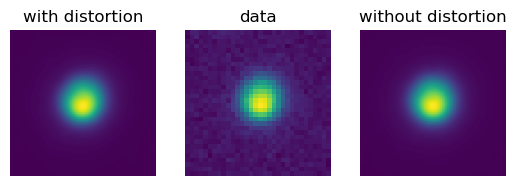

In [10]:
star_number = 0
# extract the psf pixels:
psf = get_psf_at_position(stamp_coordinates_scaled[star_number], model, kwargs)
psf_no_distortion = get_psf_at_position(None, model_no_distortion, kwargs_no_distortion)  # position does not matter here
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(psf, norm=simple_norm(psf, stretch='asinh'))
ax1.set_title('with distortion')
ax2.imshow(stars[star_number],  norm=simple_norm(stars[star_number], stretch='asinh'))
ax2.set_title('data')
ax3.imshow(psf_no_distortion,  norm=simple_norm(psf_no_distortion, stretch='asinh'))
ax3.set_title('without distortion')

for ax in [ax1, ax2, ax3]:
    ax.axis('off')

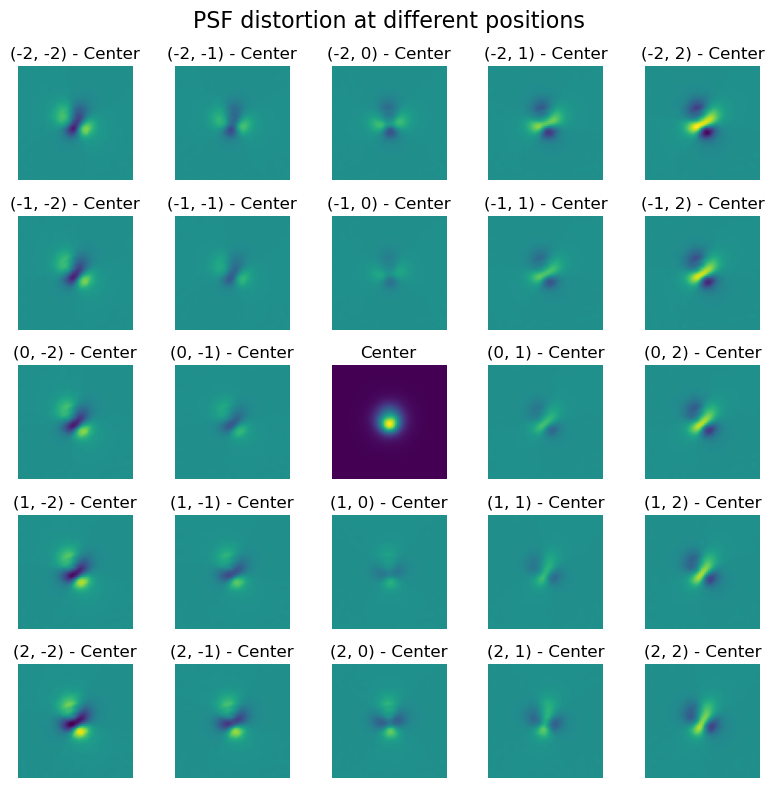

In [11]:
# by definition of our coordinates above, (0, 0) is the center of the image.
center_psf = get_psf_at_position(np.array([0, 0]), model, kwargs)

fig, axs = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle("PSF distortion at different positions", fontsize=16)

for i in range(5):
    for j in range(5):
        x, y = i - 2, j - 2  # Positions range from -2 to 2, reasonable given our rescaling above.
        if x == 0 and y == 0:
            axs[i, j].imshow(center_psf)
            axs[i, j].set_title("Center")
        else:
            psf = get_psf_at_position(np.array((x,y)), model, kwargs)
            difference = psf - center_psf
            axs[i, j].imshow(difference, vmin=-3e-4, vmax=3e-4)
            axs[i, j].set_title(f"({x}, {y}) - Center")

        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## Applying distortion later

The scenario is: the distortion coefficients and narrow PSF were saved, how do we distort it?

In [12]:
narrow_psf = get_narrow_psf_at_position(None, model, kwargs)  # equivalent to position (0, 0)
distortion_params = kwargs['kwargs_distortion']

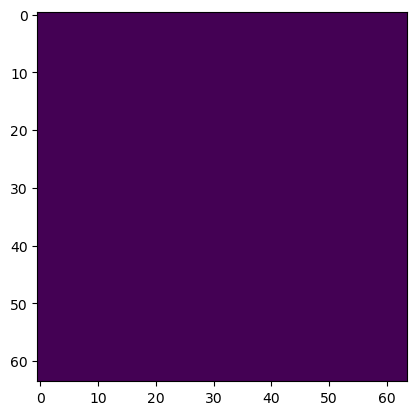

In [13]:
# use this function to apply distortion
from starred.psf.psf import apply_distortion

position = np.array([-2, 2])
distorted_from_model = get_narrow_psf_at_position(position, model, kwargs)
distorted_later = apply_distortion(narrow_psf, distortion_params, position)
plt.figure()
plt.imshow(distorted_later-distorted_from_model)